「RとStanで始めるベイズ統計モデリングによるデータ分析入門」「実践編第3部第10章 交互作用：数量×数量」を対象に，公開されているR，Stanのコードをpython，pystanのコードへと書き直した一例です。Stanの代わりにpystanを利用しています。

　本ページでは公開されていない書籍の内容については一切触れません。理論や詳しい説明は書籍を参照してください。

　なお，こちらで紹介しているコードには誤りが含まれる可能性があります。内容やコードについてお気づきの点等ございましたら，ご指摘いただけると幸いです。

# 分析の準備
## パッケージの読み込み

In [1]:
import arviz
import pystan
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Meiryo'
import seaborn as sns

# 数量×数量：モデル化

## 分析対象のデータ

In [2]:
interaction_3 = pd.read_csv('3-10-3-interaction-3.csv')
interaction_3.head(n=3)

,sales,product,clerk
0,142.5,17,3
1,193.2,38,4
2,376.7,33,9


## データの要約

In [3]:
interaction_3.describe(include='all')

,sales,product,clerk
count,100.000000,100.000000,100.000000
mean,203.964000,29.660000,4.860000
std,110.051113,11.902992,2.562433
min,35.500000,10.000000,1.000000
25%,116.700000,19.000000,3.000000
50%,178.700000,28.000000,4.000000
75%,280.600000,41.000000,7.000000
max,487.200000,50.000000,9.000000


## データの図示

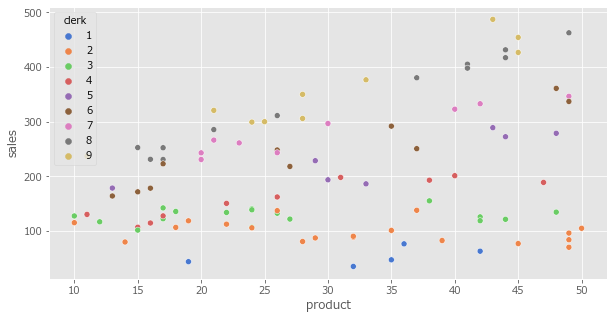

In [4]:
# グラフ描画領域の作成
plt.figure(figsize=(10,5))

# 散布図の描画
sns.scatterplot(x='product',
                y='sales',
                data=interaction_3,
                hue='clerk',
                palette='muted',
                legend='full')

# グラフの描画
plt.show()

## デザイン行列の作成

In [5]:
# salesデータのドロップ
design_mat = interaction_3.drop('sales', axis=1)

# 交互作用の追加
design_mat['product:clerk'] = design_mat['product']*design_mat['clerk']

# (Intercept)列追加
design_mat.insert(0, '(intercept)', 1)

display(design_mat)

,(intercept),product,clerk,product:clerk
0,1,17,3,51
1,1,38,4,152
2,1,33,9,297
3,1,17,8,136
4,1,48,3,144
...,...,...,...,...
95,1,18,3,54
96,1,27,3,81
97,1,14,2,28
98,1,15,3,45


## 補足：dictにまとめる

In [6]:
data_dict = dict(N = len(design_mat),
                 sales = interaction_3['sales'],
                 product = design_mat['product'],
                 clerk = design_mat['clerk'],
                 product_clerk = design_mat['product:clerk'])

## モデル化

In [7]:
# stanコードの記述
stan_code = '''
data {
    int N;
    vector[N] sales;
    vector[N] product;
    vector[N] clerk;
    vector[N] product_clerk;
}

parameters {
    real Intercept;
    real b_product;
    real b_clerk;
    real b_product_clerk;
    real<lower=0> sigma;
}

model {
    vector[N] mu = Intercept + b_product*product + b_clerk*clerk + b_product_clerk*product_clerk;
    sales ~ normal(mu, sigma);
}

generated quantities {
    // 各clerk数でmuの事後予測分布を生成
    vector[N] mu_clerk_1;
    vector[N] mu_clerk_2;
    vector[N] mu_clerk_3;
    vector[N] mu_clerk_4;
    vector[N] mu_clerk_5;
    vector[N] mu_clerk_6;
    vector[N] mu_clerk_7;
    vector[N] mu_clerk_8;
    vector[N] mu_clerk_9;
    
    for(i in 1:N){
        
        mu_clerk_1[i] = Intercept + b_product*product[i] + b_clerk*1 + b_product_clerk*product[i]*1;
        mu_clerk_2[i] = Intercept + b_product*product[i] + b_clerk*2 + b_product_clerk*product[i]*2;
        mu_clerk_3[i] = Intercept + b_product*product[i] + b_clerk*3 + b_product_clerk*product[i]*3;
        mu_clerk_4[i] = Intercept + b_product*product[i] + b_clerk*4 + b_product_clerk*product[i]*4;
        mu_clerk_5[i] = Intercept + b_product*product[i] + b_clerk*5 + b_product_clerk*product[i]*5;
        mu_clerk_6[i] = Intercept + b_product*product[i] + b_clerk*6 + b_product_clerk*product[i]*6;
        mu_clerk_7[i] = Intercept + b_product*product[i] + b_clerk*7 + b_product_clerk*product[i]*7;
        mu_clerk_8[i] = Intercept + b_product*product[i] + b_clerk*8 + b_product_clerk*product[i]*8;
        mu_clerk_9[i] = Intercept + b_product*product[i] + b_clerk*9 + b_product_clerk*product[i]*9;
        
    }
}

'''


# モデルのコンパイル
stan_model = pystan.StanModel(model_code=stan_code)

# サンプリング
interaction_stan_3 = stan_model.sampling(data=data_dict, seed=1, n_jobs=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_542eb1a5d42f1b98b09bdd791755bbd6 NOW.


## MCMCの結果の確認

In [8]:
print(interaction_stan_3.stansummary(probs=[0.025, 0.5, 0.975],
                                     pars=['Intercept', 
                                           'b_product',
                                           'b_clerk',
                                           'b_product_clerk',
                                           'sigma']))

Inference for Stan model: anon_model_542eb1a5d42f1b98b09bdd791755bbd6.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                  mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
Intercept         88.4    0.42  12.17  64.42  88.58 111.46    825   1.01
b_product        -2.26    0.01   0.37   -3.0  -2.27  -1.52    798   1.01
b_clerk           6.44    0.08   2.24   2.04   6.39  10.86    865    1.0
b_product_clerk   1.05  2.3e-3   0.07   0.92   1.05   1.19    862    1.0
sigma            20.25    0.04   1.51   17.5  20.18  23.43   1686    1.0

Samples were drawn using NUTS at Sat Sep 26 12:40:11 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


## 参考：事後分布の図示

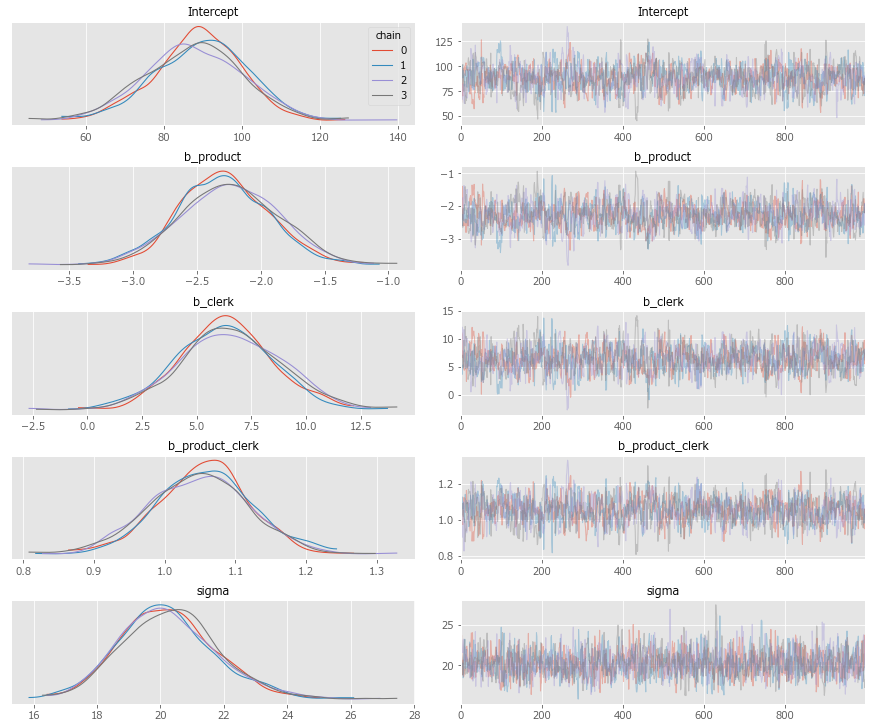

In [9]:
arviz.plot_trace(interaction_stan_3,
                 var_names=['Intercept', 
                            'b_product',
                            'b_clerk',
                            'b_product_clerk',
                            'sigma'],
                 legend=True);

# 数量×数量：係数の解釈

## 説明変数を作る

In [10]:
newdata_3 = np.matrix([
    [1,  0,   0,  0 *  0],  # Product  0, Clerk 0
    [1, 10,   0, 10 *  0],  # Product 10, Clerk 0
    [1,  0,  10,  0 * 10],  # Product  0, Clerk 10
    [1, 10,  10, 10 * 10]   # Product  0, Clerk 10
])

## 補足：係数行列を作る

In [11]:
# MCMCサンプルの抽出
mcmc_sample = interaction_stan_3.extract()

# 係数行列を作る
newdata_3_b = np.matrix([mcmc_sample['Intercept'],
                         mcmc_sample['b_product'],
                         mcmc_sample['b_clerk'],
                         mcmc_sample['b_product_clerk']])

## 予測

In [12]:
display(pd.DataFrame((newdata_3* newdata_3_b).T, 
                     columns=('Product  0, Clerk 0',
                              'Product  10, Clerk 0',
                              'Product  0, Clerk 10',
                              'Product  10, Clerk 10')).describe())

,"Product 0, Clerk 0","Product 10, Clerk 0","Product 0, Clerk 10","Product 10, Clerk 10"
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,88.397736,65.749355,152.811561,235.469824
std,12.166633,8.793806,12.773444,9.210599
min,45.308005,34.089135,103.928545,200.725057
25%,80.530964,59.959583,144.367131,229.326550
50%,88.583400,66.071283,152.766024,235.519440
75%,96.588826,71.590930,161.190498,241.541855
max,139.763340,102.745408,195.844861,266.822423


# 数量×数量：モデルの図示

## 回帰直線の図示
### 1つのグラフに回帰直線をまとめて描画する

#### 補足：図示対象のデータ

In [84]:
clerk = ['mu_clerk_1', 'mu_clerk_2', 'mu_clerk_3', 'mu_clerk_4', 'mu_clerk_5', 
         'mu_clerk_6', 'mu_clerk_7', 'mu_clerk_8', 'mu_clerk_9', ]

mu_pred = pd.DataFrame(np.zeros([len(interaction_3)*len(clerk), 4])) 


for i, c in enumerate(clerk):
    
    for j in range(len(interaction_3)):
        # 2.5・50・97.5パーセンタイルの値をデータフレームに代入
        mu_pred.iloc[j+i*len(interaction_3), 0:3] = np.percentile(mcmc_sample[c][:,j], q=[2.5, 50, 97.5])
        # 店員人数の情報列を追加
        mu_pred.iloc[j+i*len(interaction_3), -1] = str('clerk='+str(i+1))
    
# データフレームの列名を変更
mu_pred.columns = ["2.5%", "50%", "97.5%", 'num_clerk']

# # 温度情報をデータフレームに追加
mu_pred['product'] = np.array([interaction_3['product']] * 9).flatten()

# productの値に従って並び替え
mu_pred = mu_pred.sort_values('product')

#### 図示

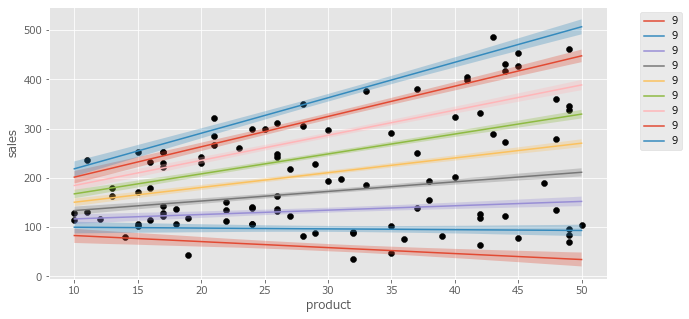

In [103]:
### グラフ描画領域の作成
plt.figure(figsize=(10, 5))

# 散布図の描画
plt.scatter(x='product',
            y='sales',
            data=interaction_3,
            c='black',
            label=None)

num_clerk = ['clerk=1', 'clerk=2', 'clerk=3', 'clerk=4', 'clerk=5',
             'clerk=6', 'clerk=7', 'clerk=8', 'clerk=9']

# 店員人数ごとに，95%区間をforループで描画
for num in num_clerk:
    
    # 特定の店員人数の時の売り上げを描画
    plt.plot(mu_pred[mu_pred['num_clerk']==num]['product'],
             mu_pred[mu_pred['num_clerk']==num]["50%"],
             label=i)
    # 95%ベイズ信頼区間を描画
    plt.fill_between(x=mu_pred[mu_pred['num_clerk']==num]['product'],
                     y1=mu_pred[mu_pred['num_clerk']==num]["2.5%"],
                     y2=mu_pred[mu_pred['num_clerk']==num]["97.5%"],
                     alpha=0.3)

# 軸ラベルの追加
plt.ylabel('sales')
plt.xlabel('product')
    
# 凡例の追加
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# グラフの描画
plt.show()

### 働く人数ごとにグラフを分ける

#### 図示

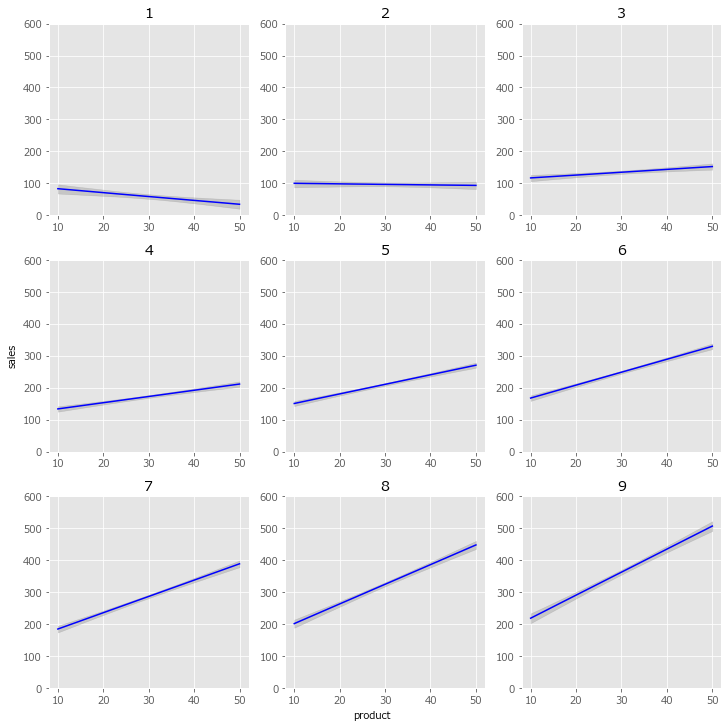

In [104]:
### グラフ描画領域の作成
fig = plt.figure(figsize=(10, 10))

for i, num in enumerate(num_clerk, 1):
    
    # 描画するサブプロットの追加
    ax = fig.add_subplot(3, 3, i)
    # 特定の店員人数の時の売り上げを描画
    ax.plot(mu_pred[mu_pred['num_clerk']==num]['product'],
            mu_pred[mu_pred['num_clerk']==num]["50%"],
            color='blue')
    # 95%ベイズ信頼区間を描画
    ax.fill_between(x=mu_pred[mu_pred['num_clerk']==num]['product'],
                    y1=mu_pred[mu_pred['num_clerk']==num]["2.5%"],
                    y2=mu_pred[mu_pred['num_clerk']==num]["97.5%"],
                    alpha=0.3,
                    color='gray')
    # サブプロットにタイトルを追加
    ax.set_title(i)
    # サブプロットのy軸を設定
    ax.set_ylim(0, 600)
    
#xラベル用
fig.text(0.5, 0, 'product', ha='center', va='center')
#yラベル用
fig.text(0, 0.5, 'sales', ha='center', va='center', rotation='vertical')

# グラフの描画
plt.tight_layout()
plt.show()